In [110]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy.optimize import curve_fit

def band_score(rate,res):
    X,Y = np.meshgrid(np.linspace(-2,2,res),np.linspace(-2,2,res))
    x_flat,y_flat = X.flatten(), Y.flatten()
    loc = np.stack([x_flat,y_flat])
    def spectrum(ratemap):
        res = ratemap.shape[0]
        fft_rate = np.abs(nf.fftshift(nf.fft2(ratemap)))
        fft_rate[:int(res/2),:] = 0
        return fft_rate
    ratemap = rate.reshape(res,res)
    fft_rate = spectrum(ratemap)

    # 定义高斯函数
    def gaussian(loc, A, k, phi, sigma):
        x = loc[0]
        y = loc[1]
        return A * np.exp(-((x - k*np.cos(phi))**2 / (2 * sigma**2) + (y - k*np.sin(phi))**2 / (2 * sigma**2)))

    initial_guess = [1.0, 0.2, 0.0, 0.1]

    try:
        params, _ = curve_fit(lambda xy, A, k, phi, sigma: gaussian(xy, A, k, phi, sigma), 
                                (loc), 
                                fft_rate.ravel(), 
                                p0=initial_guess, 
                                bounds=([0, 0.2, 0, 0.05], [np.inf, 1, np.pi, 0.5]),
                                maxfev=1000)  # 增加最大函数评估次数
    except RuntimeError as e:
        # print("Warning:", e)
        # 使用 `full_output=True` 调用 leastsq 获取最后一步的参数
        from scipy.optimize import leastsq
        params, _, _, _, _ = leastsq(
            lambda xy: fft_rate.ravel() - gaussian(loc, *xy), initial_guess or np.ones(len(initial_guess)), full_output=True, maxfev=1000
        )
        # print("Returning last known parameters:", params)
    # return popt, pcov
    dx = 4.4/res
    k0 = params[1]
    phi = params[2]
    sigma = params[3]
    kx = k0*np.cos(phi)/2*(1/dx/2)*np.pi*2
    ky = k0*np.sin(phi)/2*(1/dx/2)*np.pi*2
    k = np.sqrt(kx**2+ky**2)# The maximum frequency is 1/dx, correspoding k = np.pi*2/dx
    # print(params)
    gx = gaussian(loc, params[0], params[1], params[2], params[3])

    # 计算相关性
    band_scores = np.dot(fft_rate.ravel(), gx.ravel()) / (1e-8+np.linalg.norm(fft_rate.ravel()) * np.linalg.norm(gx.ravel())) / sigma

    return band_scores, ratemap, params, fft_rate, gx, k, phi, sigma


In [111]:
from tqdm import tqdm
import numpy as np

res = 50

data = np.load('rate_map.npy')
print(data.shape)
Ng = data.shape[0]
T = data.shape[1]
score = np.zeros(Ng,)
k = np.zeros(Ng,)
phi = np.zeros(Ng,)
sigma = np.zeros(Ng,)
ratemap = np.zeros([Ng,50,50])
for i in tqdm(range(Ng)):
    rate = data[i]-np.mean(data[i])
    band_scores, rm, params, fft_rate, gx, k[i], phi[i], sigma[i] = band_score(rate,res)
    ratemap[i] = rm
    score[i] = band_scores

(4096, 2500)


100%|██████████| 4096/4096 [00:48<00:00, 83.76it/s] 


Text(0.5, 1.0, 'band score distribution')

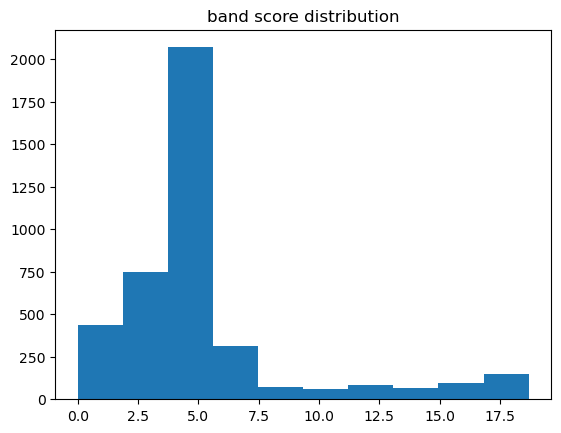

In [112]:

plt.hist(score)
plt.title('band score distribution')

selected cell number: 438


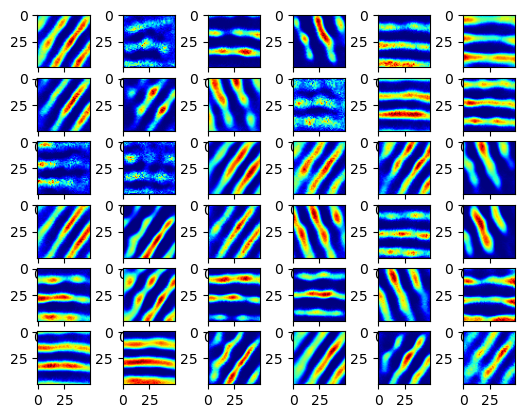

In [113]:
score_thres = 10.
index = np.argsort(-score)
n_sub = 6
fig,ax = plt.subplots(n_sub,n_sub)
# print(score[index[800]])
index_band = np.where(score>score_thres)[0]
# index_band = np.
print('selected cell number:',index_band.shape[0])

# print(len(index_band))
for i in range(n_sub**2):
    x = i // n_sub
    y = i % n_sub
    ax[x,y].imshow(ratemap[index_band[i]],cmap='jet')
    

[1.74829746 1.76       1.76       ... 1.34128561 1.31073342 1.40912679]
(438,)


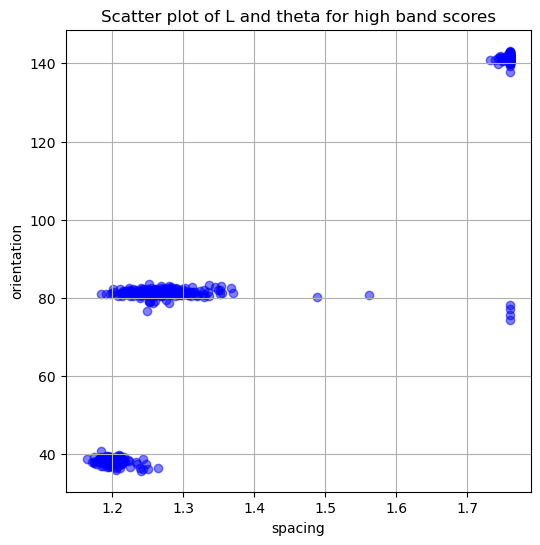

In [114]:
# 周期和朝向
L = 2*np.pi / k
print(L)

## 绘制 k_mag_opts 和 theta_opts 的散点图
plt.figure(figsize=(6, 6))
high_band_idxs = np.where(score > score_thres)[0]
print(high_band_idxs.shape)
plt.scatter(L[high_band_idxs], phi[high_band_idxs]/np.pi*180, c='blue', alpha=0.5)
plt.xlabel('spacing')
plt.ylabel('orientation')
plt.title('Scatter plot of L and theta for high band scores')
plt.grid(True)
plt.show()

(array([123., 143.,  48.,   8.,   0.,   1.,   1.,   0.,   0., 114.]),
 array([1.16452129, 1.22406916, 1.28361703, 1.3431649 , 1.40271277,
        1.46226065, 1.52180852, 1.58135639, 1.64090426, 1.70045213,
        1.76      ]),
 <BarContainer object of 10 artists>)

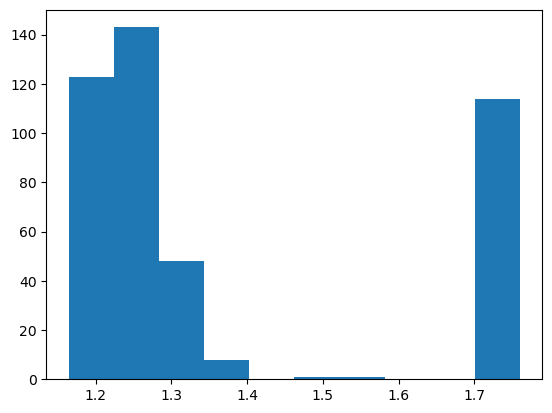

In [115]:
plt.hist(L[index_band])
# print(score)

(array([112.,   0.,   0.,   7., 209.,   0.,   0.,   0.,   0., 110.]),
 array([ 35.7445811 ,  46.49408086,  57.24358063,  67.99308039,
         78.74258015,  89.49207992, 100.24157968, 110.99107945,
        121.74057921, 132.49007898, 143.23957874]),
 <BarContainer object of 10 artists>)

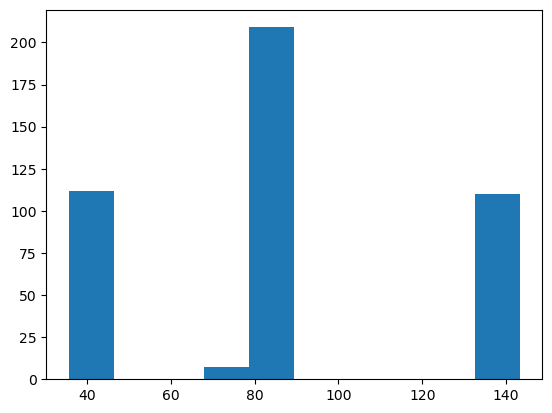

In [116]:
plt.hist(phi[index_band]/np.pi*180)

In [117]:
# 计算相位 fai
Ng = k.shape[0]
phase = np.zeros(Ng)  
N_band = high_band_idxs.shape[0]
# "loc" here is different from what we use in "band score", it's the real physical location
X,Y = np.meshgrid(np.linspace(-2.2,2.2,res),np.linspace(-2.2,2.2,res))
x_flat,y_flat = X.flatten(), Y.flatten()
loc = np.stack([x_flat,y_flat])

for i in range(N_band):
    j = 1j  # 虚部
    k_vec = np.array([k[high_band_idxs[i]]*np.cos(phi[high_band_idxs[i]]),k[high_band_idxs[i]]*np.sin(phi[high_band_idxs[i]])]).reshape(1,2) #1*2
    loc_phase = np.mod(np.dot(k_vec,loc), L[high_band_idxs[i]])/L[high_band_idxs[i]]*np.pi*2-np.pi #1*Ng
    phase[high_band_idxs[i]] = np.angle(np.sum(np.exp(loc_phase*1j)*rate)/np.sum(rate)) # 1

# print(phase)
# 

(array([ 13.,  19.,  25.,  14.,  24.,  33., 151., 101.,  35.,  23.]),
 array([-3.12115922, -2.49519696, -1.86923471, -1.24327245, -0.61731019,
         0.00865207,  0.63461432,  1.26057658,  1.88653884,  2.5125011 ,
         3.13846335]),
 <BarContainer object of 10 artists>)

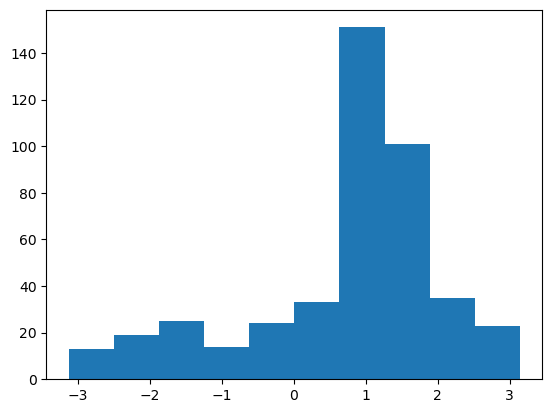

In [118]:
plt.hist(phase[high_band_idxs])

In [119]:
# 提取四个网络
high_band_idxs = np.where(score > score_thres)[0]

L_low_theta_low = np.where((L > 0) & (L < 1.4) & (phi/np.pi*180 > 0) & (phi/np.pi*180 < 60))[0]
L_low_theta_mid= np.where((L > 0) & (L < 1.4) & (phi/np.pi*180 > 60) & (phi/np.pi*180 < 100))[0]
L_high_theta_mid = np.where((L > 1.7) & (phi/np.pi*180 > 60) & (phi/np.pi*180 < 100))[0]
L_high_theta_high = np.where((L > 1.7) & (phi/np.pi*180 > 120))[0]

# 和high_band_idxs取交集
L_low_theta_low = np.intersect1d(L_low_theta_low, high_band_idxs)
L_low_theta_mid = np.intersect1d(L_low_theta_mid, high_band_idxs)
L_high_theta_mid = np.intersect1d(L_high_theta_mid, high_band_idxs)
L_high_theta_high = np.intersect1d(L_high_theta_high, high_band_idxs)

In [120]:

# 连接权重矩阵
J = np.load('J_matrix.npy')
# phase_low_theta_low_L = phase[L_low_theta_low]
print(phase.shape)
print(L_low_theta_low.shape)
# print(L_low_theta_low.shape)
L_low_theta_low_idxs = L_low_theta_low[np.argsort(phase[L_low_theta_low])]
L_low_theta_mid_idxs = L_low_theta_mid[np.argsort(phase[L_low_theta_mid])]
L_high_theta_mid_idxs = L_high_theta_mid[np.argsort(phase[L_high_theta_mid])]
L_high_theta_high_idxs = L_high_theta_high[np.argsort(phase[L_high_theta_high])]


(4096,)
(112,)


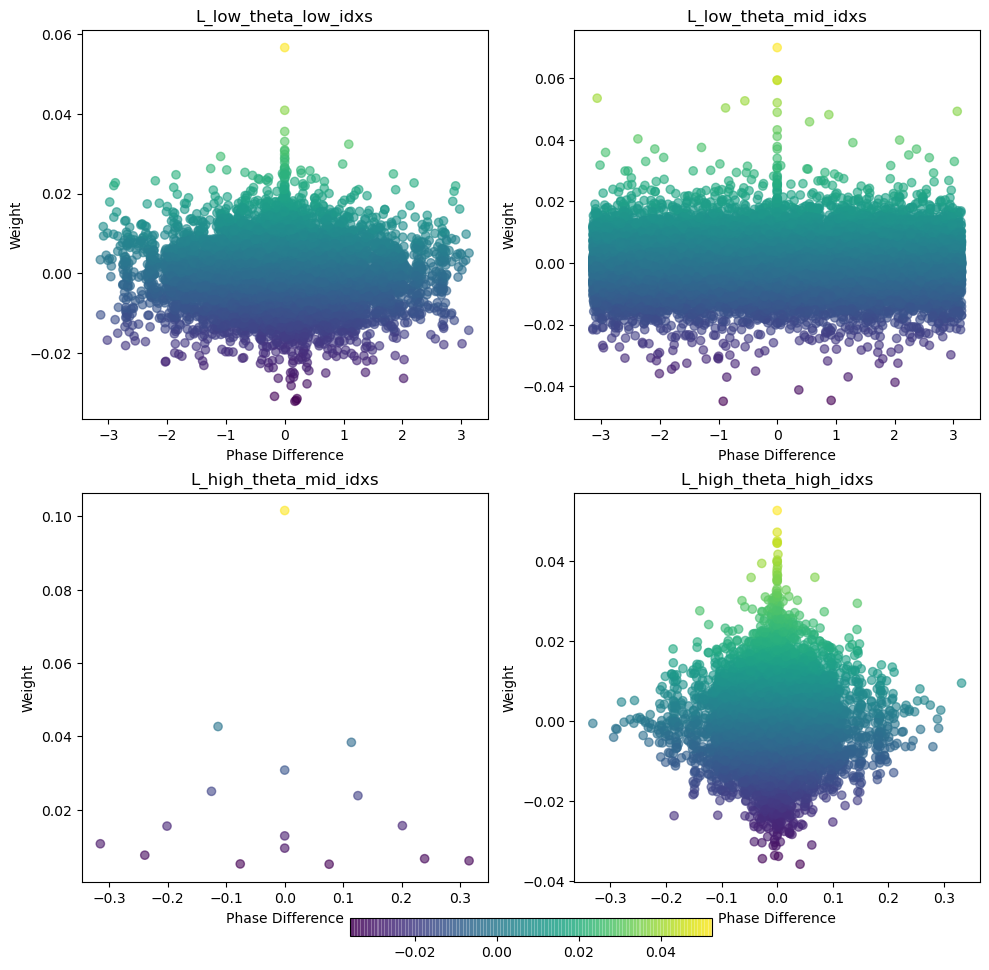

In [126]:
# Calculate phase differences
def phase_difference(phases):
    phase_diff = np.angle(np.exp(1j * (phases[:, None] - phases[None, :])))
    return phase_diff

# Plot weights as a function of phase difference
def plot_weights_vs_phase_diff(ax, idxs, title):
    phases = phase[idxs]
    weights = J[idxs][:, idxs]
    phase_diff = phase_difference(phases)
    
    sc = ax.scatter(phase_diff.flatten(), weights.flatten(), c=weights.flatten(), cmap='viridis', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Phase Difference')
    ax.set_ylabel('Weight')
    ax.set_facecolor('white')  # Set background color to white
    return sc

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot L_low_theta_low_idxs
sc = plot_weights_vs_phase_diff(axs[0, 0], L_low_theta_low_idxs, 'L_low_theta_low_idxs')

# Plot L_low_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[0, 1], L_low_theta_mid_idxs, 'L_low_theta_mid_idxs')

# Plot L_high_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[1, 0], L_high_theta_mid_idxs, 'L_high_theta_mid_idxs')

# Plot L_high_theta_high_idxs
sc = plot_weights_vs_phase_diff(axs[1, 1], L_high_theta_high_idxs, 'L_high_theta_high_idxs')

plt.tight_layout()
fig.colorbar(sc, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.savefig('conn.png')

(112, 112)
(210, 210)
(4, 4)
(110, 110)


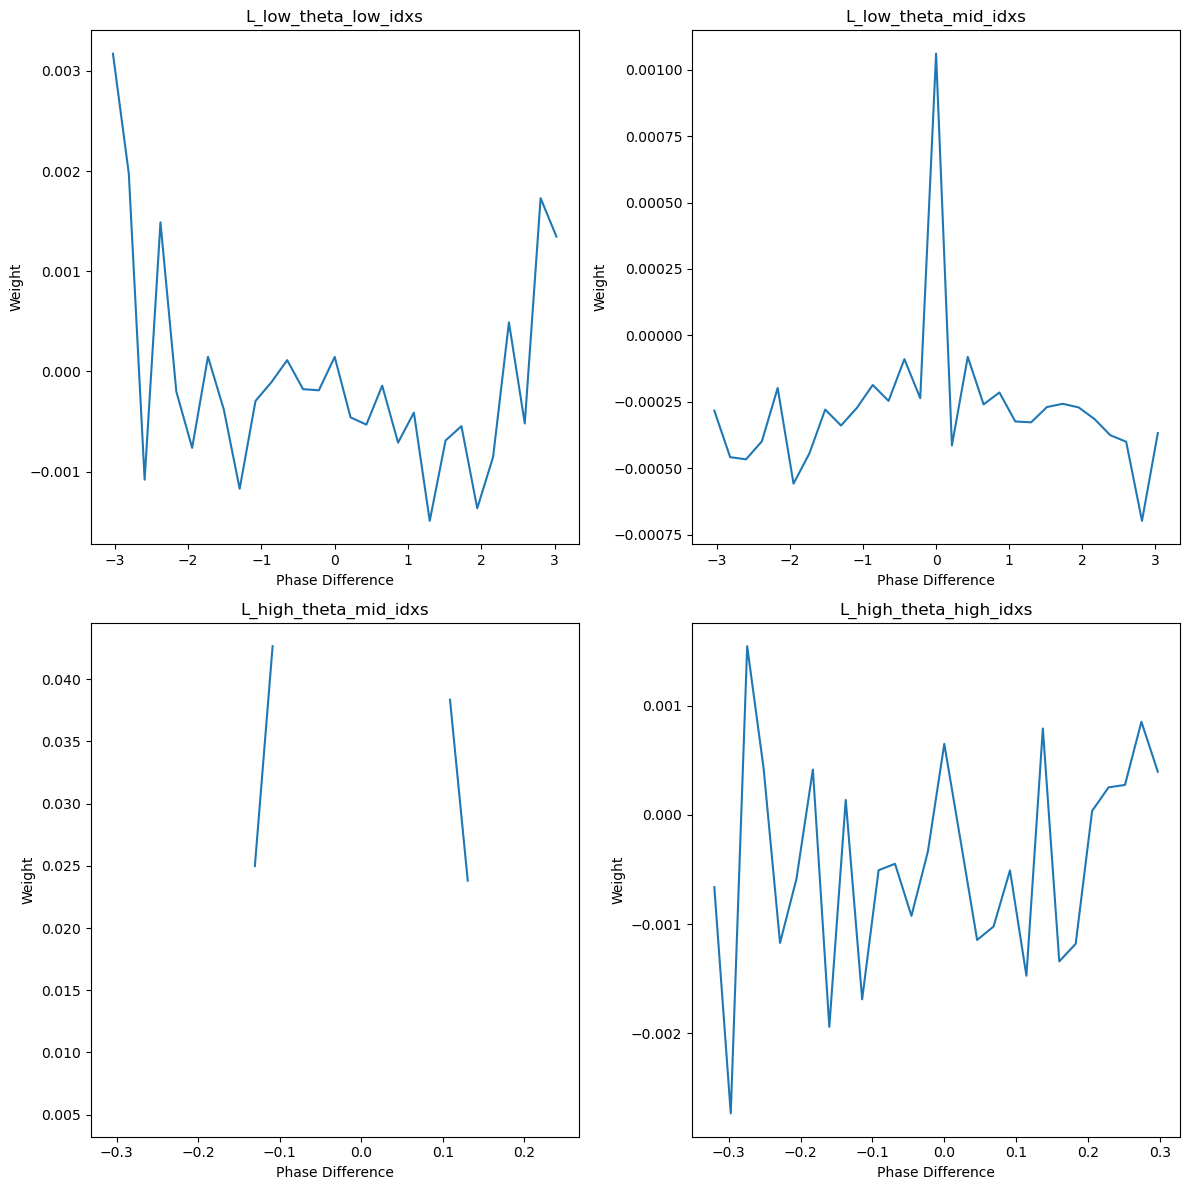

In [122]:

from scipy.ndimage import gaussian_filter1d
# Calculate phase differences
def phase_difference(phases):
    phase_diff = np.angle(np.exp(1j * (phases[:, None] - phases[None, :])))
    return phase_diff
# print(J.shape)
# Plot weights as a function of phase difference
def plot_weights_vs_phase_diff(ax, idxs, title, type='positive'):
    phases = phase[idxs]
    weights = J[idxs][:, idxs]
    print(weights.shape)
    phase_diff = phase_difference(phases)
    x = phase_diff.flatten()
    y = weights.flatten() 
    # index_postive =  np.where(y0>=0)[0]
    # # index_negative  =  np.where(y0<=0)[0]
    # # index_new = np.where(type=='positive', index_postive, index_negative)
    # x = x0[index_postive]
    # y = y0[index_postive]
    bins = np.linspace(np.min(x),np.max(x),30)

    mean_values = []
    for i in range(len(bins) - 1):
        mask = (x >= bins[i]) & (x < bins[i + 1])  # 创建掩码选择在区间内的 X
        if np.any(mask):  # 确保区间内有数据
            mean_value = np.mean(y[mask])  # 计算对应 Y 的平均值
        else:
            mean_value = np.nan  # 如果区间内没有数据，返回 NaN
        mean_values.append(mean_value)
    
    # sigma = 2  # 高斯核的标准差
    # smoothed_mean_values = gaussian_filter1d(mean_values, sigma)
    # sc = ax.scatter(phase_diff.flatten(), weights.flatten(), c=weights.flatten(), cmap='viridis', alpha=0.6)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    # sc = ax.bar(bin_centers, mean_values, width=np.diff(bins), alpha=0.5, color='orange', edgecolor='black', label='平均值')

    sc = ax.plot(bin_centers, mean_values)
    ax.set_title(title)
    ax.set_xlabel('Phase Difference')
    ax.set_ylabel('Weight')
    # ax.set_facecolor('white')  # Set background color to white
    return sc

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot L_low_theta_low_idxs
sc = plot_weights_vs_phase_diff(axs[0, 0], L_low_theta_low_idxs, 'L_low_theta_low_idxs')

# Plot L_low_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[0, 1], L_low_theta_mid_idxs, 'L_low_theta_mid_idxs')

# Plot L_high_theta_mid_idxs
sc = plot_weights_vs_phase_diff(axs[1, 0], L_high_theta_mid_idxs, 'L_high_theta_mid_idxs')

# Plot L_high_theta_high_idxs
sc = plot_weights_vs_phase_diff(axs[1, 1], L_high_theta_high_idxs, 'L_high_theta_high_idxs')

plt.tight_layout()
# fig.colorbar(sc, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

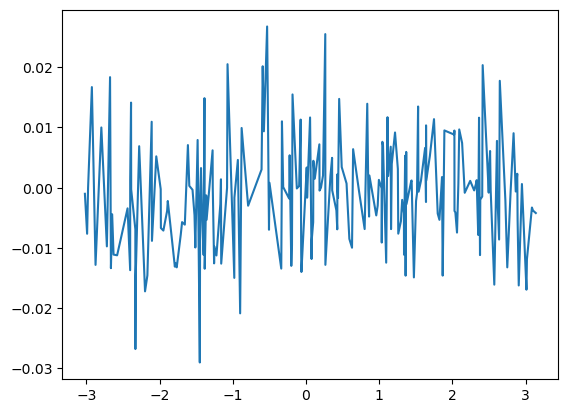

In [123]:
index_study = L_low_theta_mid_idxs
phases_study = phase[index_study]
weights = J[index_study][:, index_study]
index_neuron = 101
plt.plot(phases_study,weights[index_neuron,:])
# plt.hist(weights.flatten())

(210,)


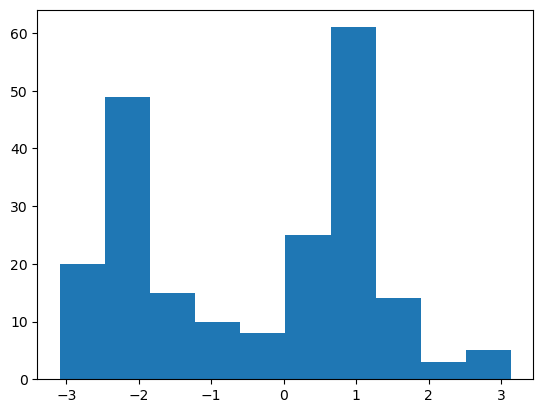

In [124]:

N_study = phases_study.shape[0]
phase_bias = np.zeros(N_study) 
for i in range(N_study):
    phase_bias[i] = np.angle(np.sum(np.exp(phases_study*1j)*weights[i,:])/np.sum(weights[index_neuron,:]))

plt.hist(phase_bias)
# print(N_study)
print(phase_bias.shape)